In [1]:
import os
import sys
import time
import numpy as np
import cv2
import random

from tqdm import tqdm
from glob import glob

from utils.common import *
from pathlib import Path
from shapely.geometry import Polygon, MultiPoint, Point
from matplotlib import pyplot as plt

In [2]:
data_path = Path("./data/simple")
detect_path = Path("./runs/detect/simple")
table_data_path = Path("./data/layout")
table_detect_path = Path("./runs/detect/layout")
h, w = 1456, 1928

K = np.array([
    [975.813843, 0, 960.973816],
    [0, 975.475220, 729.893921],
    [0, 0, 1]
])
num_cams = 4

cam_poses = {}
for i in range(num_cams):
    with open(f'./camera_poses/{i:05d}.txt', 'r') as f:
        lines = f.readlines()
        pose = []
        for line in lines:
            data = list(map(float, line.split(" ")))
            pose.append(data)
        pose = np.array(pose)
        cam_poses[f'cam{i}'] = pose.reshape(4, 4)
plane_coeffs = get_plane_coeffs(K, cam_poses)

# read 1 simple data from each camera for now
# img = [cv2.imread(str(data_path / f"cam{id}" / "00000.jpg")) for id in range(num_cams)]

# img has dimensions 4 x N, where 4 is the number of cameras and N = # of simple data per camera.
img = []

for id in range(num_cams):
    data = []
    directory = directory = str(data_path) + f"/cam{id}"
    for file in os.listdir(directory):
        img_path = directory + f"/{file}"
        data.append(cv2.imread(img_path))
    img.append(data)



In [3]:
bboxes = [
    [1034.999564,  504.000224],
    [1034.999564,  696.000032],
    [1211.999604,  696.000032],
    [1211.999604,  504.000224]]
mx_px = np.array([4.24737756, 6.90199759])
mi_px = np.array([-2.55125312, 0.51182116])
width = 800
height = int(width * (mx_px[0] - mi_px[0]) / (mx_px[1] - mi_px[1]))

print(width, height)

800 851


In [5]:
# later change this part to parse through all files, not just 00000
# object classes that we would like to detect: 0 for person class, __ for laptop
# 63, 67, 

paths = [detect_path, table_detect_path]

table_output = {}
person_output = {}
# laptop_output = {}

def find_normalized_bbox_info(filename):
    px_t = []
    for id in range(num_cams):
        tables = []
        person = []
        # laptop = []
        for i in range(len(paths)):
            path = str(paths[i] / f"cam{id}" / "labels" / str(filename))
            with open(path, "r") as f:
                lines = f.readlines()
                for line in lines:
                    data = list(map(float, line.split(" ")))
                    bboxes = np.array([
                        [(data[1] - data[3] / 2) * w, (data[2] - data[4] / 2) * h],
                        [(data[1] - data[3] / 2) * w, (data[2] + data[4] / 2) * h],
                        [(data[1] + data[3] / 2) * w, (data[2] + data[4] / 2) * h],
                        [(data[1] + data[3] / 2) * w, (data[2] - data[4] / 2) * h],
                    ])
                    # cam plane -> 3d position
                    bboxes = pixel2plane(bboxes, K, cam_poses[f'cam{id}'][:3,:], plane_coeffs)

                    # 3d position -> table plane 2d
                    bboxes = plane2layout(bboxes, plane_coeffs)
                    if (data[0] == 60 and i != 0):  # detect tables from layout path
                        tables.append(bboxes)
                    if (data[0] == 0 and i == 0):   # detect objects from simple path
                        person.append(bboxes)
                    # if (data[0] == 74 and i == 0):
                    #     laptop.append(bboxes)
            
            if (len(tables) > 0):
                mx_t, mi_t = get_bbox(np.concatenate(tables, axis=0))
                px_t += [mx_t] + [mi_t]
            table_output[f'cam{id}'] = tables

            # if (len(person) > 0):
            #     mx_p, mi_p = get_bbox(np.concatenate(person, axis=0))
            #     px_p += [mx_p] + [mi_p]
            person_output[f'cam{id}'] = person

            # laptop_output[f'cam{id}'] = laptop
    return table_output, person_output, px_t, [mx_t, mi_t]


table_output, person_output, px_t, m_table = find_normalized_bbox_info("00000.txt")
mx_t, mi_t = m_table[0], m_table[1]


lengths_t = [len(table_output[f'cam{id}']) for id in range(4)]
print(lengths_t)

lengths_p = [len(person_output[f'cam{id}']) for id in range(4)]
print(lengths_p)

mx_px_t, mi_px_t = get_bbox(np.stack(px_t, axis=0))
print(mx_px_t, mi_px_t)



[6, 5, 6, 6]
[1, 2, 1, 1]
[ 4.24737743 -0.51182119] [-2.55125316 -6.90199772]


In [6]:
def matchByOverlap(after_bboxes, before_bboxes_transformed):
    overlaps = []
    for i, after_bbox in enumerate(after_bboxes):
        after_bbox_polygon = Polygon(after_bbox)
        for j, before_bbox_transformed in enumerate(before_bboxes_transformed):
            before_bbox_transformed_polygon = Polygon(before_bbox_transformed)
            if(after_bbox_polygon.intersects(before_bbox_transformed_polygon)):
                overlap = after_bbox_polygon.intersection(before_bbox_transformed_polygon).area
                total = after_bbox_polygon.area + before_bbox_transformed_polygon.area - overlap
                percentage = overlap/total
                # percentage = overlap/after_bbox_polygon.area
                overlaps.append([i, j, percentage])
    overlaps.sort(key = lambda x : x[-1], reverse=True)
    
    after_indices = set(range(len(after_bboxes)))
    before_indices = set(range(len(before_bboxes_transformed)))

    selected = []
    for i, j, _ in overlaps:
        if i in after_indices and j in before_indices:
            # i : index in bboxes (cam(i+1))
            # j : index in transformed_bboxes (cam(i) -> cam(i+1))
            selected.append([i, j])
            after_indices.remove(i)
            before_indices.remove(j)

    return selected

group length:  4
group length:  1


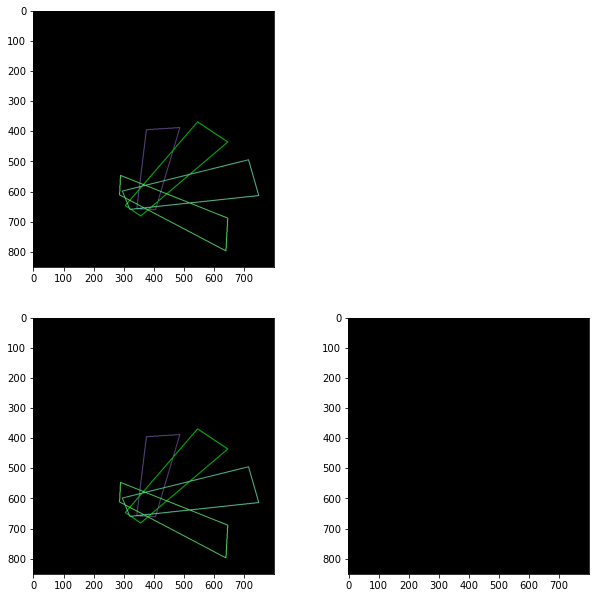

In [7]:
# find overlapping people in simple

# input: output_dict, mx_px_t, mi_px_t
# output_dict: dictionaries that have previously been found such as table_output or person_output
# output_dict: a dictionary that maps each camera to an array of bounding boxes for some type of object such as table or person

def find_overlap(output_dict, mx_coord, mi_coord):
    width = 800
    height = int(width * (mx_coord[0] - mi_coord[0]) / (mx_coord[1] - mi_coord[1]))

    plt.figure(figsize=(16, 16))
    out = np.zeros((height, width, 3), dtype=np.uint8)
    objects_dict = {}
    col = []
    for id in range(num_cams):
        col.append(tuple(np.random.rand(3) * 255))
        objects_dict[f'cam{id}'] = p2px(output_dict[f'cam{id}'], mi_coord, mx_coord, width, height)
        out = cv2.polylines(out, objects_dict[f'cam{id}'], True, col[id], 2)

    plt.subplot(3, 3, 1)
    plt.imshow(out)

    edge = {}
    V = []
    checked = {}
    for id in range(num_cams):
        for t in range(len(objects_dict[f'cam{id}'])):
            edge[(id, t)] = []
            checked[(id, t)] = False
            V.append((id, t))

    for id1 in range(num_cams):
        for id2 in range(id1 + 1, num_cams):
            matched = matchByOverlap(objects_dict[f'cam{id1}'], objects_dict[f'cam{id2}'])
            for t1, t2 in matched:
                edge[(id1, t1)].append((id2, t2))
                edge[(id2, t2)].append((id1, t1))

    object_groups = []
    for v in V:
        if checked[v]:
            continue
        checked[v] = True
        queue = [v]
        g = []
        while len(queue) > 0:
            now = queue.pop(0)
            g.append(now)
            for u in edge[now]:
                if not checked[u]:
                    checked[u] = True
                    queue.append(u)
        object_groups.append(g)
    
    return objects_dict, object_groups, col


people, people_groups, color = find_overlap(person_output, mx_px_t, mi_px_t)

for i, group in enumerate(people_groups):
        print('group length: ', len(group))
        im = np.zeros((height, width, 3), dtype=np.uint8)
        for cid, pid in group:
            im = cv2.polylines(im, [people[f'cam{cid}'][pid]], True, color[cid], 2)
        plt.subplot(3, 3, i + 3 + 1)
        plt.imshow(im)


In [8]:
# find overlapped region
# input: object_dict, groups, option
# option: if this is True, then the function only finds the intersection when 4 polygons intersect
# if this is False, then the function finds the intersection for every group of polygons

def find_intersection(objects_dict, groups, option):
    group_intersection = []
    for i, group in enumerate(groups):
        intersection = None
        if (option == True and len(group) < 4):
            continue
        for cid, pid in group:
            elem = objects_dict[f'cam{cid}'][pid]
            polygon = Polygon(elem)
            print(f'polygon: {polygon}')
            if (intersection is None):
                intersection = polygon 
            else:
                intersection = polygon.intersection(intersection)
        group_intersection.append(intersection)
    return group_intersection 



group length:  3
group length:  4
group length:  4
group length:  4
group length:  4
group length:  4


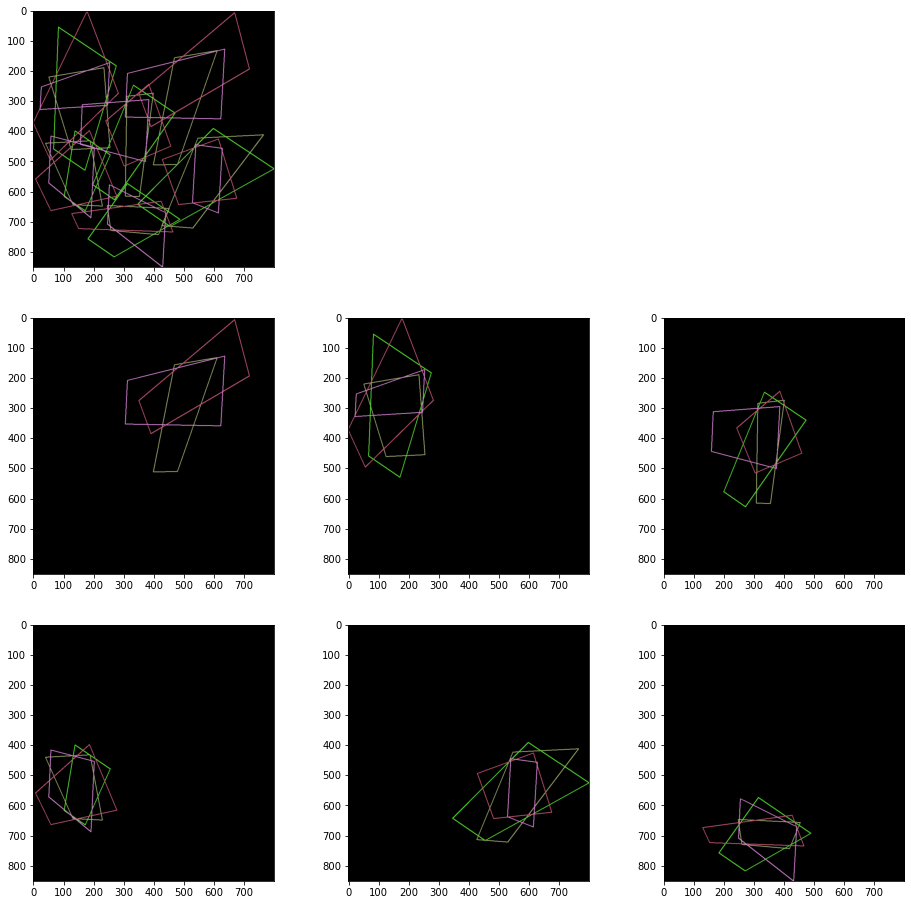

In [9]:
# only use overlapping table from layout, not simple because simple data cannot gaurantee that all tables have bounding boxes

tables, table_groups, color = find_overlap(table_output, mx_px_t, mi_px_t)

for i, group in enumerate(table_groups):
        print('group length: ', len(group))
        im = np.zeros((height, width, 3), dtype=np.uint8)
        for cid, pid in group:
            im = cv2.polylines(im, [tables[f'cam{cid}'][pid]], True, color[cid], 2)
        plt.subplot(3, 3, i + 3 + 1)
        plt.imshow(im)
    


In [10]:
people_intersection = find_intersection(people, people_groups, True)
table_intersection = find_intersection(tables, table_groups, False)

polygon: POLYGON ((376 394, 344 657, 406 660, 487 387, 376 394))
polygon: POLYGON ((546 368, 306 646, 357 681, 646 435, 546 368))
polygon: POLYGON ((715 494, 296 598, 321 659, 749 613, 715 494))
polygon: POLYGON ((646 688, 290 546, 287 611, 640 797, 646 688))
polygon: POLYGON ((469 155, 399 511, 479 510, 611 131, 469 155))
polygon: POLYGON ((669 5, 351 274, 391 384, 718 192, 669 5))
polygon: POLYGON ((636 126, 313 207, 306 352, 623 358, 636 126))
polygon: POLYGON ((52 219, 126 460, 255 454, 235 188, 52 219))
polygon: POLYGON ((84 53, 68 458, 172 529, 276 182, 84 53))
polygon: POLYGON ((179 0, 0 371, 57 495, 283 273, 179 0))
polygon: POLYGON ((254 171, 27 252, 23 327, 247 313, 254 171))
polygon: POLYGON ((311 283, 306 615, 353 616, 399 273, 311 283))
polygon: POLYGON ((333 246, 198 577, 270 627, 471 339, 333 246))
polygon: POLYGON ((384 243, 241 365, 302 515, 457 449, 384 243))
polygon: POLYGON ((384 294, 163 311, 157 443, 373 500, 384 294))
polygon: POLYGON ((41 439, 132 643, 230 648, 

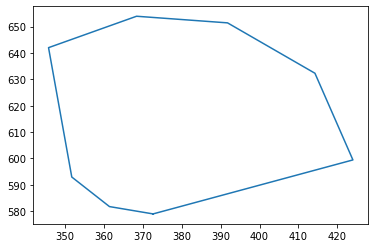

In [11]:
# find overlapped region
# people overlap
n = len(people_intersection)
for i in range(n):
    x, y = people_intersection[i].exterior.xy
    plt.plot(x, y)


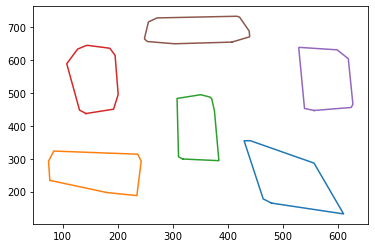

In [12]:
# table overlap

n = len(table_intersection)
for i in range(n):
    x, y = table_intersection[i].exterior.xy
    plt.plot(x, y)

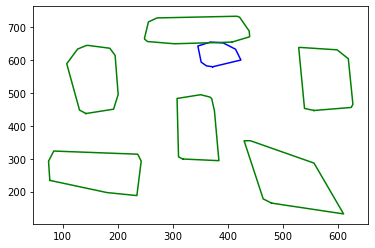

In [14]:
# tables are in green, people are in blue

n = len(people_intersection)
for i in range(n):
    x, y = people_intersection[i].exterior.xy
    plt.plot(x, y, 'b')

n = len(table_intersection)
for i in range(n):
    x, y = table_intersection[i].exterior.xy
    plt.plot(x, y, 'g')

In [ ]:
# compute distance between an item people_intersection and all items in table_intersection
# find the item in table_intersection that minimizes this distance